# Solanki, Shivam - Homework 2

**Due: Monday 18th February**

We numerically explore the relationship between error distributions, objective functions (least squares, least absolute deviation, and weighted least squares), and computational speed.

The following simulation creates a data set according to
$$y_i = \beta_1 + \beta_2 x_i + \beta_3 x_i^2 + \epsilon_i.$$

We generate $n$ observations from this model for $x$ on an equally spaced grid $[0,1]$. For $Y^{(t)}$, the errors ($\epsilon_i$) have a t-distribution with 2 degrees of freedom. For $Y^{(n)}$, the errors have a standard normal distribution. For $Y^{(w)}$, the errors are heteroscedastic: $\epsilon_i|\sigma_i^2 \sim N(0,\sigma_i^2)$,  where $\sigma_i \sim 0.1 + \text{Exp}(1)$ (that is, an exponential distribution shifted $0.1$ to the right). We plot each of these data sets and the true regression function.

In [1]:
set.seed(1234)
n <- 500
x <- seq(from=0,to=1,length.out=n)
X <- cbind(1,x,x^2)
beta <- matrix(c(1,2,4),nrow=3)
Yt <- X%*%beta + rt(n,df=2)
Yn <- X%*%beta + rnorm(n)
sig <- 0.1 + rexp(n) 
Yw <- X%*%beta + rnorm(n,sd=sig)

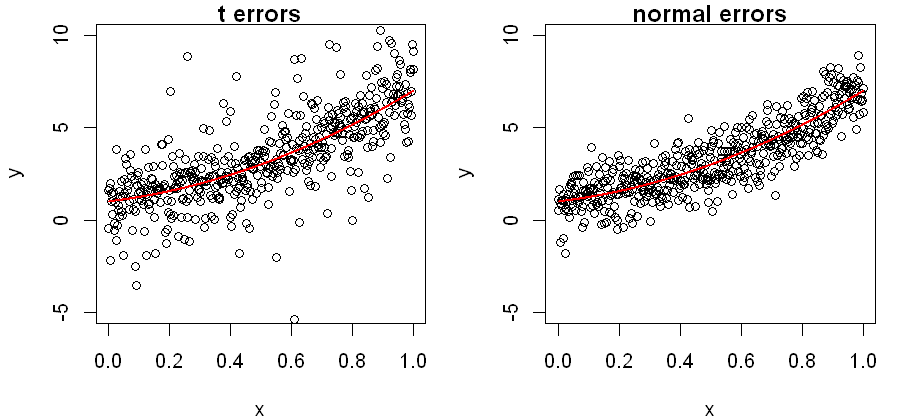

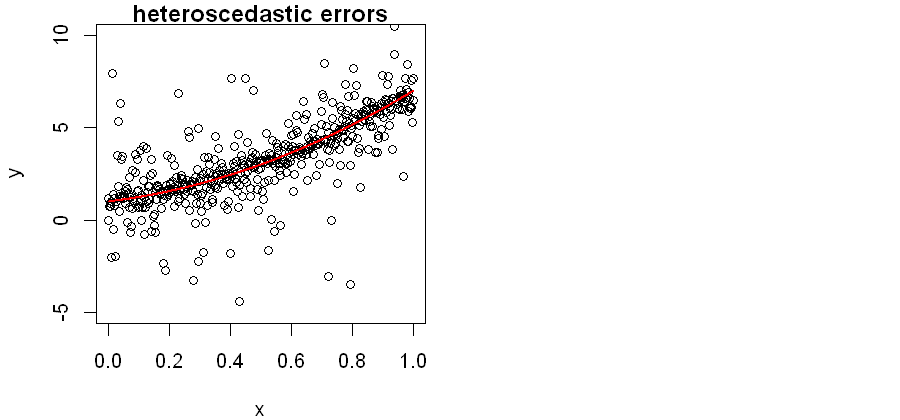

In [2]:
options(repr.plot.width=7.5,repr.plot.height=3.5)
par(mar=c(4,4,1,1),mfcol=c(1,2))
ylim <- c(-5,10)
plot(X[,2],Yt,xlab="x",ylab="y",main="t errors",ylim=ylim)
points(X[,2],X%*%beta,type='l',col='red',lwd=2)
plot(X[,2],Yn,xlab="x",ylab="y",main="normal errors",ylim=ylim)
points(X[,2],X%*%beta,type='l',col='red',lwd=2)
plot(X[,2],Yw,xlab="x",ylab="y",main="heteroscedastic errors",ylim=ylim)
points(X[,2],X%*%beta,type='l',col='red',lwd=2)

The t distribution produces a lot of outliers (some outliers are not shown because we restricted the y-axis to ylim in each plot) and there are also a lot of outliers in the case of the heteroscedastic errors. Given the data, out goal is to infer the parameters $\beta$. We will mainly consider two methods. The least squares method we discussed in class is
$$ \beta_{LS} = \text{argmin}_{\beta} (y_i - \beta_1 - \beta_2 x_i - \beta_3 x_i^2)^2 =  \text{argmin}_{\beta} (Y - X\beta)^T(Y - X\beta) = (X^TX)^{-1}X^TY$$
A second possibility is to find the [least absolute deviations](https://en.wikipedia.org/wiki/Least_absolute_deviations) estimator. We call this $\beta_{LAD}$ which has the form
$$\beta_{LAD} = \text{argmin}_{\beta} |y_i - \beta_1 - \beta_2 x_i - \beta_3 x_i^2|.$$
This may also be known as $L_1$ regression or quantile regression with the $0.5$ quantile.

In this homework you will fit both $\beta_{LS}$ and $\beta_{LAD}$ and compare the methods based on parameter estimation accuracy and speed. In the case of the heteroscedastic errors dataset we will also compare to the weighted least squares estimator $\beta_{WLS}= (X^TWX)^{-1}X^TWY$, where $W$ is a diagonal matrix, with the diagonal given by $1/\sigma_i^2$ for $i=1,\dots,n$ (assume that the $\sigma_i$ are known). 

## Question 1

Fixing $X$, generate the $Y^{(t)}$, $Y^{(n)}$, and $Y^{(w)}$ datasets $N=100$ times (note that $n$ is the sample size and $N$ is the number of times we run the simulation). For the  $Y^{(t)}$ and $Y^{(n)}$ datasets, compute $\beta_{LS}$ and $\beta_{LAD}$ each time. Since $\beta$ is a vector of length $3$, this will result in 4 matrices (LS for $Y^{(t)}$ and $Y^{(n)}$ and LAD for $Y^{(t)}$ and $Y^{(n)}$) with $N$ rows and 3 columns (you could store this output in other formats as well, but matrices are convenient). For the $Y^{(w)}$ datasets, compute all three estimators $\beta_{LS}$, $\beta_{LAD}$, and $\beta_{WLS}$, and similarly store them in matrices. 

Make scatterplots of $\beta_2$ versus $\beta_3$ estimates for each data type and each estimator. This will produce seven scatterplots in total. Mark the true $\beta_2$ and $\beta_3$ on each plot and comment of the quality of the estimators in the different settings. Your scatterplots should look similar to the ones below.

**Tips for Fitting** 

- For fitting $\beta_{LS}$, you have many options in R (lm, lm.fit) and python (scipy.linalg.lstsq, sklearn.linear_model.LinearRegression). 
- For fitting $\beta_{LAD}$ in R you can use l1fit from the package L1pack or  rq.fit from quantreg. For fitting $\beta_{LAD}$ in python the options are somewhat more limited:
    * [statsmodels](http://www.statsmodels.org/dev/examples/notebooks/generated/quantile_regression.html) requires use of pandas, calls the quantreg R package
    * generic optimizer such as [scipy.optimize](https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html)   
  The later is a more general method that will likely be slower. But scipy.optimize is general and will be useful for many other problems. You may also use any other optimizer you find. 
- For fitting $\beta_{WLS}$ in R you can use for example lm.wfit or lsfit (the latter may be more convenient here). In Python you can use for example the sample_weight option in sklearn.linear_model.LinearRegression or statsmodels.regression.linear_model.WLS. 

(requires internet connection to view)

<img src="https://david-jones-statistics.github.io/statcomp/hw/betaT.png">

(requires internet connection to view)

<img src="https://david-jones-statistics.github.io/statcomp/hw/betaNorm.png">

(requires internet connection to view)

<img src="https://david-jones-statistics.github.io/statcomp/hw/betaHet.png">

In [22]:
import numpy as np 
import pandas as pd 
import statsmodels.formula.api as smf 
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [74]:
def data_generation():
    '''
    Generating data sets based on the conditions provided 
    in the question
    '''
    n = 500 
    x = np.linspace(start=0, stop=1, num=n)
    X = pd.DataFrame({"one": [1]*500,"x": x,"x2": x**2})
    beta = np.array([1, 2, 4])
    Yt = np.dot(X, beta) + np.random.standard_t(df= 2, size=n)
    Yn = np.dot(X, beta) + np.random.standard_normal(n)
    sig = 0.1 + np.random.standard_exponential(n)
    Yw = np.dot(X, beta) + np.random.normal(scale= sig ,size = n)

    #Creating datframe 
    Yt = pd.Series(Yt)
    Yn = pd.Series(Yn)
    Yw = pd.Series(Yw)
    df = pd.concat([X,Yt,Yn,Yw], axis=1)
    df.columns = ['One','X','X2','Yt','Yn','Yw']
    return df


In [24]:
def fit_LAD(df): 
    '''
    Fitting LAD Regression Model
    Args: df = dataframe
    Output: res = Result of the fitted regression model
    '''
    df = data_generation()
    data =df 
    mod = smf.quantreg('Yt ~ X+X2', data)
    res = mod.fit(q=.5)
    return res


In [25]:
def fit_LS(df):
    '''
    Fitting LS Regression Model
    Args: df = dataframe
    Output: res = Coefficients of the fitted regression model
    '''
    df = data_generation()
    
    lr = LinearRegression()
    lr.fit(df[['X','X2']],df['Yt'],)    
    res = lr.coef_
    return res


In [26]:
def simulation_coeff(N):
    '''
    Fitting Regression Models and storing the Beta values
    Args: N = number of times simulation needs to be run 
    Output: coeff_ = coefficients of the fitted regression line
    '''
    coeff_LAD = []
    coeff_LS = []
    for i in range(N):
        a = fit_LAD(data_generation())
        coeff_LAD.append([a.params[1],a.params[2]])
        c = fit_LS(data_generation())
        coeff_LS.append([c[0],c[1]])
    return coeff_LAD, coeff_LS


In [27]:
def coeff_df():
    '''
    Converting the coefficients obtained from regression to a dataframe
    Args: None
    Output: df_LAD = dataframe of coefficients of the LAD regression line
            df_LS = dataframe of coefficients of the LS regression line
    '''
    a,b = simulation_coeff(100)
    df_LAD = pd.DataFrame(a, columns = ['Beta2','Beta3'])
    df_LS = pd.DataFrame(b, columns = ['Beta2', 'Beta3'])
    return df_LAD, df_LS

C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)

C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)

C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)

C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)

C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Shiva\Anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:193: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weig

Text(0.5, 1.0, 'LS-t errors')

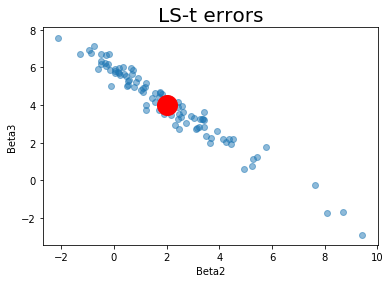

In [28]:
#Using functions to obtain answers 
LAD,LS = coeff_df()
plt.scatter(LS['Beta2'],LS['Beta3'],alpha = 0.5);
plt.scatter(2,4, 400, c ="r");
plt.xlabel("Beta2", fontsize =10);
plt.ylabel("Beta3", fontsize =10); plt.title("LS-t errors", fontsize = 20)

C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)

C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)

C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)

C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)

C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)

Text(0.5, 1.0, 'LAD-t errors')

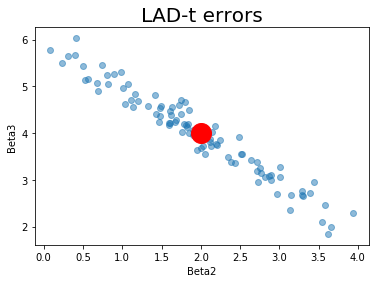

In [29]:
#Plotting scatterplot of Beta values for LS regression line
LAD,LS = coeff_df()
plt.scatter(LAD['Beta2'],LAD['Beta3'],alpha = 0.5);
plt.scatter(2,4, 400, c ="r");
plt.xlabel("Beta2", fontsize =10);
plt.ylabel("Beta3", fontsize =10); plt.title("LAD-t errors", fontsize = 20)

In [30]:
#Now repeating the same steps for normally distributed data
def fit_LAD(df): 
    '''
    Fitting LAD Regression Model
    Args: df = dataframe
    Output: res = Result of the fitted regression model
    '''
    df = data_generation()
    data =df 
    mod = smf.quantreg('Yn ~ X+X2', data)
    res = mod.fit(q=.5)
    return res


In [32]:
def fit_LS(df):
    '''
    Fitting LS Regression Model
    Args: df = dataframe
    Output: res = Coefficients of the fitted regression model
    '''
    df = data_generation()
    
    lr = LinearRegression()
    lr.fit(df[['X','X2']],df['Yn'],)    
    res = lr.coef_
    return res


C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)

C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)

C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)

C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)

C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)

Text(0.5, 1.0, 'LAD-normal errors')

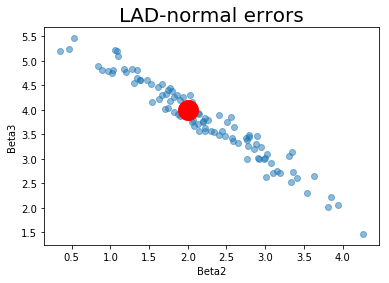

In [33]:
#Plotting Beta values of LAD regression line for normally distributed data 
LAD,LS = coeff_df()
plt.scatter(LAD['Beta2'],LAD['Beta3'],alpha = 0.5);
plt.scatter(2,4, 400, c ="r");
plt.xlabel("Beta2", fontsize =10);
plt.ylabel("Beta3", fontsize =10); plt.title("LAD-normal errors", fontsize = 20)

C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)

C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)

C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)

C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)

C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)

Text(0.5, 1.0, 'LS-normal errors')

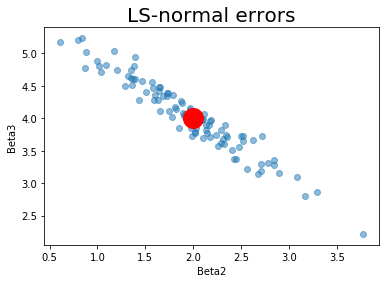

In [34]:
#Plotting Beta values of LS regression line for normally distributed data 
LAD,LS = coeff_df()
plt.scatter(LS['Beta2'],LS['Beta3'],alpha = 0.5);
plt.scatter(2,4, 400, c ="r");
plt.xlabel("Beta2", fontsize =10);
plt.ylabel("Beta3", fontsize =10); plt.title("LS-normal errors", fontsize = 20)

In [35]:
#Fitting LAD regression model for heteroskedastic errors
def fit_LAD(df): 
    '''
    Fitting LAD Regression Model
    Args: df = dataframe
    Output: res = Result of the fitted regression model
    '''
    df = data_generation()
    data =df 
    mod = smf.quantreg('Yw ~ X+X2', data)
    res = mod.fit(q=.5)
    return res


In [36]:
#Fitting LS regression model for heteroskedastic errors
def fit_LS(df):
    '''
    Fitting LS Regression Model
    Args: df = dataframe
    Output: res = Coefficients of the fitted regression model
    '''
    df = data_generation()
    
    lr = LinearRegression()
    lr.fit(df[['X','X2']],df['Yw'],)    
    res = lr.coef_
    return res


C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Shiva\Anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:193: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached."

C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)

C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)

C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Shiva\Anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:193: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached."

C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)

Text(0.5, 1.0, 'LAD-Heteroscadastic errors')

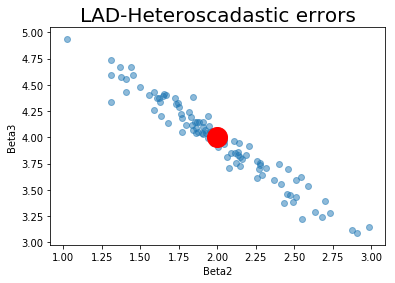

In [38]:
#Plotting Beta values of LAD regression line for heteroskedastic errors 
LAD,LS = coeff_df()
plt.scatter(LAD['Beta2'],LAD['Beta3'],alpha = 0.5);
plt.scatter(2,4, 400, c ="r");
plt.xlabel("Beta2", fontsize =10);
plt.ylabel("Beta3", fontsize =10); plt.title("LAD-Heteroscadastic errors", fontsize = 20)

C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)

C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)

C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)

C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)

C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Shiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)

Text(0.5, 1.0, 'LS-Heteroscadastic errors')

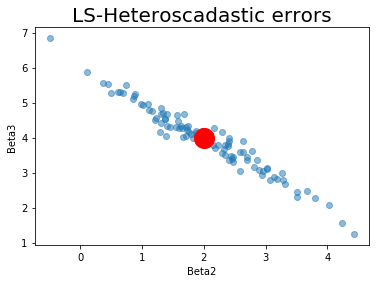

In [39]:
#Plotting Beta values of LS regression line for heteroskedastic errors 
LAD,LS = coeff_df()
plt.scatter(LS['Beta2'],LS['Beta3'],alpha = 0.5);
plt.scatter(2,4, 400, c ="r");
plt.xlabel("Beta2", fontsize =10);
plt.ylabel("Beta3", fontsize =10); plt.title("LS-Heteroscadastic errors", fontsize = 20)

In [49]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [69]:
def WLS(df):
    '''
    Fitting Weighted LS Regression Model
    Args: df = dataframe
    Output: res = Coefficients of the fitted regression model
    '''
    df = data_generation()
    Y = df['Yw']
    X = df[['One','X','X2']]
    ols = sm.OLS(Y,X).fit()
    residual = ols.resid
    var = residual.var(ddof=int(ols.df_model)+1)
    wts = [var]*500
    w = np.array(wts)
    res = sm.WLS(Y, X, weights=1/((w**2))).fit()
    return res

In [70]:
def simulation_coeff(N):
    '''
    Fitting Weighted Linear Regression Models and storing the Beta values
    Args: N = number of times simulation needs to be run 
    Output: coeff_WLS = coefficients of the fitted WLS
    '''
    coeff_WLS = []
    for i in range(N):
        a = WLS(data_generation())
        coeff_WLS.append([a.params[1],a.params[2]])
    return coeff_WLS

In [71]:
def coeff_df():
    '''
    Converting the coefficients obtained from regression to a dataframe
    Args: None
    Output: df_WLS = dataframe of coefficients of the WLS regression line
    '''
    a = simulation_coeff(100)
    df_WLS = pd.DataFrame(a, columns = ['Beta2','Beta3'])
    return df_WLS

Text(0.5, 1.0, 'WLS-heteroskedastic errors')

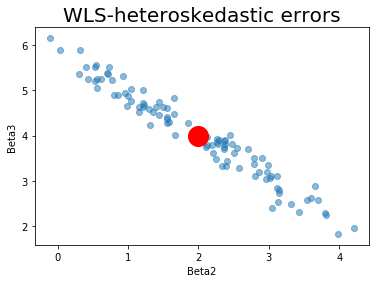

In [72]:
#Plotting Beta values of WLS regression line for heteroskedastic errors 
WLS = coeff_df()
plt.scatter(WLS['Beta2'],WLS['Beta3'],alpha = 0.5);
plt.scatter(2,4, 400, c ="r");
plt.xlabel("Beta2", fontsize =10);
plt.ylabel("Beta3", fontsize =10); 
plt.title("WLS-heteroskedastic errors", fontsize = 20)

## Question 2

Compare the speed of $\beta_{LS}$ to $\beta_{LAD}$ using a package such as microbenchmark in R or some of the tools [here](https://jakevdp.github.io/PythonDataScienceHandbook/01.07-timing-and-profiling.html) in python. Empirically determine the computational complexity (in $n$) of $\beta_{LAD}$ and $\beta_{LS}$ (we know from theoretical analysis that $\widehat{\beta}_{LS}$ should be linear in $n$).

In [79]:
def data_generation(n):
    '''
    Args: n = number of observations
    Generating data sets based on the conditions provided 
    in the question
    ''' 
    x = np.linspace(start=0, stop=1, num=n)
    X = pd.DataFrame({"one": [1]*500,"x": x,"x2": x**2})
    beta = np.array([1, 2, 4])
    Yt = np.dot(X, beta) + np.random.standard_t(df= 2, size=n)
    Yn = np.dot(X, beta) + np.random.standard_normal(n)
    sig = 0.1 + np.random.standard_exponential(n)
    Yw = np.dot(X, beta) + np.random.normal(scale= sig ,size = n)

    #Creating datframe 
    Yt = pd.Series(Yt)
    Yn = pd.Series(Yn)
    Yw = pd.Series(Yw)
    df = pd.concat([X,Yt,Yn,Yw], axis=1)
    df.columns = ['One','X','X2','Yt','Yn','Yw']
    return df

In [80]:
def fit_LS(df,n):
    '''
    Fitting LS Regression Model
    Args: df = dataframe
    Output: res = Coefficients of the fitted regression model
    '''
    df = data_generation(n)
    
    lr = LinearRegression()
    lr.fit(df[['One','X','X2']],df['Yw'],)    
    res = lr.coef_
    return res

In [86]:
def simulation_coeff(N, n):
    '''
    Fitting Weighted Linear Regression Models and storing the Beta values
    Args: N = number of times simulation needs to be run 
    Output: coeff_WLS = coefficients of the fitted WLS
    '''
    coeff_LS = []
    for i in range(N):
        a = fit_LS(data_generation(n), n)
        #coeff_LS.append([a.params[1],a.params[2]])
    return coeff_LS

In [101]:
LS_time = [361, 367, 408, 490, 602, 891, 1430, 2600]
LAD_time = [3590, 3700, 3960, 5760, 7520, 11700, 18200, 31900]
n = [500, 1000, 2000, 4000, 8000, 16000, 32000, 64000]

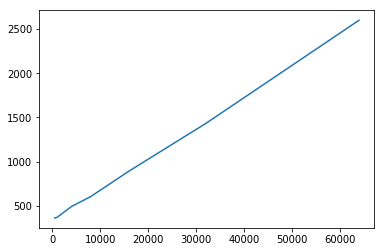

In [102]:
plt.plot(n, LS_time)

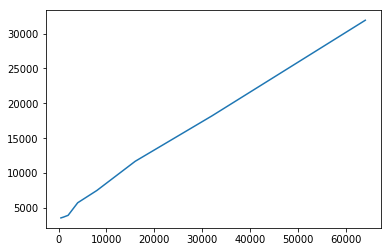

In [103]:
plt.plot(n, LAD_time)

In [41]:
#Loading Data in the memory to compare 2 speed and complexity of two different linear models
df = data_generation()
lr = LinearRegression()
%timeit lr.fit(df[['X','X2']],df['Yw'],)    


2.13 ms ± 83.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [42]:
%timeit lr.coef_

85.3 ns ± 0.167 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


Both Least Square(LS) Regression Model and Least Absoulute Deviation Model(LAD) has been fitted to the same data and the time taken to fit the model as well as store the coefficients of the fitted line was recorded. It was found out that the least squares regression model is faster than LAD model.
Thus we can say that 𝛽𝐿𝑆 is more efficient to 𝛽𝐿𝐴𝐷

**Computational Complexity**

For a least squares regression with n training examples and c features, it takes:

O(c^2n) to multiply XT by X
O(cn) to multiply XT by Y
O(c^3) to compute the LU (or Cholesky) factorization of XTX and use that to compute the product (XTX)−1(XTY)
Asymptotically, O(C^2N) dominates O(CN) so we can forget the O(cn) part.

Since we are using the normal equation so n>c- otherwise the matrix XTX would be singular (and hence non-invertible), which means that O(c^2n) asymptotically dominates O(c^3).

Therefore the total time complexity is O(c^2n). 

Now c can be taken out since it is a constant for a particular model with fixed number of predictors.

Hence, the computational complexity of 𝛽𝐿𝑆 is O(n)

For Least Absolute Deviation,

the objective function is to minimize the sum of the residual absolute values, that is,
 
 ∑|ei|=∑∣∣yi−βˆ0−βˆ1xi∣∣
 
 we can observe that no matrix multiplication is required here or the terms are not squared. Only the number or iterations is 
 
 high leading to greater time taken in minimizing the Least absolute Deviation of the error term.
 
 Therefore, the computational complexity of 𝛽𝐿𝐴𝐷 is O(n). 
